# Radar

Ovaj primer ilustruje primenu diskretne Furijeove transformacije u radu radara. Radari su uređaji koji emituju radio talase i obrađuju njihove refleksija u cilju ispitivanja okoline. Mogu se susresti u avijaciji, meteorologiji, geologiji i mnogim drugim oblastima. 


Radar koji se nadalje razmatra spada u grupu linearno modulisanih FMCW (Frequency-Modulated Continuous-Wave) radara čije frekvencije emitovanja signala variraju u vremenu. Pokušaćemo da ispitamo kako izgleda frekvencijskog spektra ovog radara ukoliko su poznata rastojanja i veličine objekata koje detektuje. U praksi je pristup problemu inverzan - na osnovu frekvencijskih spektara radara se određuju udaljenosti objekata i njihove dimenzije.
 
Ovde je cilj da se uverimo da ovakav pristup zaista ima smisla (zato je u naslovu vežbe postavljen pridev *lažni* uz radar), a da u sledećem primeru prođemo kroz jedan realan primer u pravom smeru. 

<img src='assets/radar_flow.png'> 

Na slici je dat prikaz osnovnih komponenti radara i način na koji su one uvezane. Pored posebnih antena koje se koriste za emitovanje i prijem signala, tu su mikser komponenta (engl. mixer) u kojoj se množe primljeni signal i replika emitovanog signala dobijena komponentom za dupliranje (engl. coupler), niskopropusni filter koji vrši selekciju frekvencija signala (engl. low-pass filter), pojačivači frekvencija primljenog i emitovanog signala (engl. recieve and transmit apmplifier), kao i analogno-digitalni konverteri (engl. analog to digital converter) i generatori signala (engl waveform generator).

Ukoliko se dva signala čije su frekvencije redom $x$ i $y$ pomnože, na osnovu adicionih formula važi identitet $$ \sin(xt) \sin(yt) = \frac{1}{2} \left[ \sin \left( (x - y)t + \frac{\pi}{2} \right) - \sin \left( (x + y)t + \frac{\pi}{2} \right) \right] $$. Ako se rezultujući signal dalje propusti kroz niskopropusni filter faktor $\sin((x + y)t + \frac{\pi}{2})$ će se eliminisati pa će ostati samo faktor $\sin( (x - y)t + \frac{\pi}{2})$ koji ukazuje da se na osnovu razlika u frekvencijama emitovanog i primljenog signala može zaključivati o udaljenosti objekata koji radar detektuje. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Prvo ćemo uvesti parametre koji opisuju radar.

In [2]:
# frekvencija uzorkovanja u hercima
fs = 78125          

# vreme uzorkovanja - na svakih ts sekundi se meri vrednost signala
ts = 1.0 / fs         

# broj uzoraka 
N = 2048

# ukupno vreme uzorkovanja signala u sekundama (engl. akka effective sweep duration)
Teff = N * ts  
                    
# opseg frekvencija signala koji se postize za ukupno vreme uzorkovanja signala (engl. effective bandwidth)
Beff = 100e6         
                            
# velicina promene frekvencije u jedinici vremena (engl. frequency sweep rate) u Hz/s        
S = Beff / Teff 

# brzina radio talasa priblizno odgovara brzini svetlosti
c = 3e8  

Dalje ćemo uvesti informacije o objektima koji se detektuju, a potom i o signalnima koji im odgovaraju. 

In [3]:
# rastojanja objekata (u metrima)
R = np.array([100, 137, 154, 159,  180])  

# velicine objekata 
M = np.array([0.33, 0.2, 0.9, 0.02, 0.1])  

In [4]:
# vremena uzorkovanja signala
t = np.arange(N) * ts 

# frekvencijske razlike 
# ako je signal putovao tx sekundi, frekvencija radara se u medjuvremenu promenila za tx*S
# tx odgovara vremenu signala potrebnom da od radara stigne do objekta i 
# vrati se nazad pa je formula po kojoj se vreme tx moze izracunati predjeni_put/brzina = 2*R/c
# time se frekvencijska razlika radara moze izraziti sa
fd = 2 * S * R / c      

# slucajno odabrane faze signala duz kojih su objekti detektovani
P = np.array([0, np.pi / 2, np.pi / 3, np.pi / 5, np.pi / 6])  

# signali koji odgovaraju detektovanim objektima 
# pokrivaju se istovremeno oblici svih detektovanih signala 
# signal0 = np.cos(2 * pi * fd[0] * t)
# signal1 = np.cos(2 * pi * fd[1] * t + pi / 2)
# signal2 = np.cos(2 * pi * fd[2] * t + pi / 3)
# signal3 = np.cos(2 * pi * fd[3] * t + pi / 5)
# signal4 = np.cos(2 * pi * fd[4] * t + pi / 6)

signals = np.cos(2 * np.pi * fd * t.reshape(N, 1) + P)

# kombinovani signal koji radar prima odgovara sumi reflektovanih signala pomnozenih velicinama objekata
# v_sim = (0.33 * signal0) + (0.2 * signal1) + (0.9 * signal2) + (0.02 * signal3) + (0.1 * signal4)
v_sim = np.sum(M * signals, axis=1)

Zatim ćemo izvršiti Furijeovu transformaciju signala.

In [5]:
V_sim = np.fft.fft(v_sim)

Možemo prikazati dobijeni frekvencijski spektar npr. samo pozitivni deo.

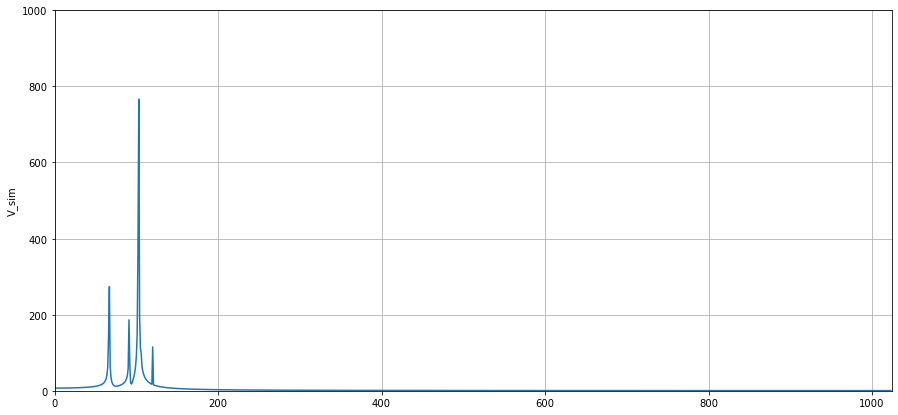

In [6]:
plt.figure(figsize=(15, 7))
plt.xlim(0, N//2)
plt.ylim(0, 1000)
plt.ylabel('V_sim')
plt.grid()
plt.plot(np.abs(V_sim[:N//2]))
plt.show()

Zatim ćemo promeniti skalu prikaza vrednosti - preći ćemo na vrednosti izražene u decibelima (vrednosti signala se obi čno izražavaju u decibelima).  Funkcija `dB` sa argumentom `power` koji predstavlja snagu signala izračunava logaritam količnika $\frac{power}{max(power)}$ u decibelima. 

In [7]:
def dB(power):

    power = np.abs(power)
    power /= power.max()

    return 20 * np.log10(power)

Sada ćemo iscrtati frekvencijske spektre signala ali na nešto preciznijoj skali i u decibelima. 

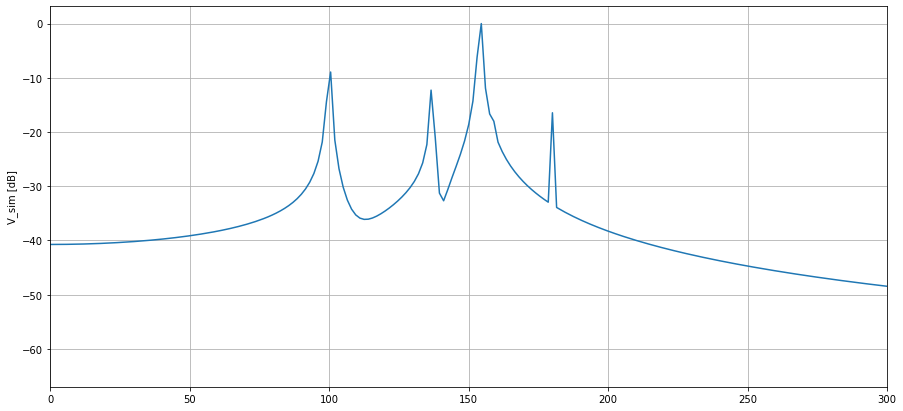

In [8]:
plt.figure(figsize=(15, 7))

# moguce vrednosti frekvencija signala (engl. range bins)
range = np.arange(N // 2) * c / 2 / Beff

# iscrtavamo frekvencijske spektre signala
plt.plot(range, dB(V_sim[:N // 2]))

# postavljamo obelezje y-ose
plt.ylabel('V_sim [dB]')

# menjamo skale na frekvencijskoj osi da bi preciznije mogli da vidimo pikove
plt.xlim(0, 300)  

# zbog finijih ocitavanja postavljamo i mrezu podela
plt.grid()

plt.show()

Sa slike možemo da zaključimo da frekvencije pikova zaista odgovaraju udaljenostima objekata i da je ispravno sa stanovišta detekcije objekata koristiti frekvencijske spektre. Jedna frekvencija ipak nije prepoznata jer radar ima poteskoću da razlikuje bliske frekvencije (154 i 159 u ovom slučaju). Zbog toga ćemo iskoristiti prozorsku funkciju, npr. Kasierov prozor, da bismo pojačali vrednosti signala.

In [9]:
window = np.kaiser(N, 6.1) 
V_sim_win = np.fft.fft(window * v_sim)

Iscrtajmo sada novi frekvencijski spektar signala.

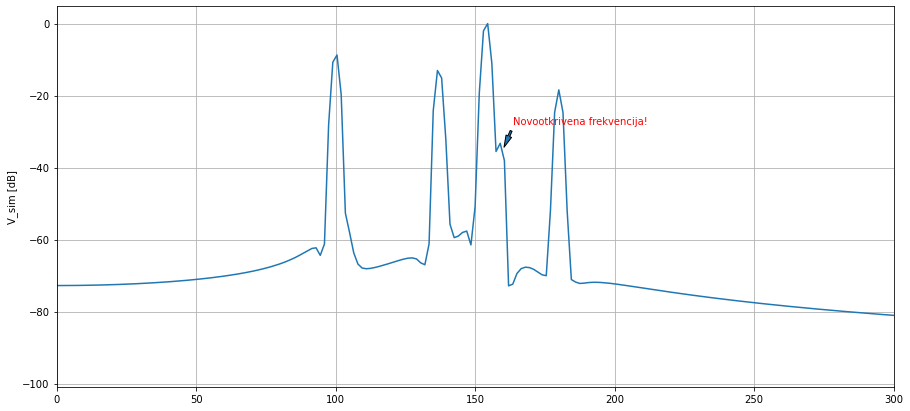

In [10]:
plt.figure(figsize=(15, 7))
range = np.arange(N // 2) * c / 2 / Beff
plt.plot(range, dB(V_sim_win[:N // 2]))
plt.ylabel('V_sim [dB]')
plt.xlim(0, 300)  
plt.grid()

plt.annotate('Novootkrivena frekvencija!', (160, -35),
             xytext=(10, 25), textcoords='offset points', color='red',
             arrowprops=dict(width=2, headwidth=6, headlength=12, shrink=0.1))

plt.show()

Zahvaljujući prozorskoj funkciji, sada imamo još jedan pik koji odgovara novoprepoznatom objektu.

Za dalja čitanja o radarima možete pogledati sledeće linkove:  
* [http://www.radartutorial.eu/](http://www.radartutorial.eu/)

* [https://en.wikipedia.org/wiki/Radar](https://en.wikipedia.org/wiki/Radar)

Sledeći primer se tiče rada sa realnim podacima i vizuelizacije detektovanog objekta.